[[29241. 29241. 28561. ... 34969. 29929. 16900.]
 [29584. 29241. 28900. ... 32041. 27225. 15876.]
 [29584. 29241. 28900. ... 36100. 31329. 19881.]
 ...
 [  484.   625.   841. ...  8836.  7744.  7921.]
 [  400.   625.   900. ...  9801.  9025.  9409.]
 [  324.   576.   900. ... 10201. 10201. 10816.]]


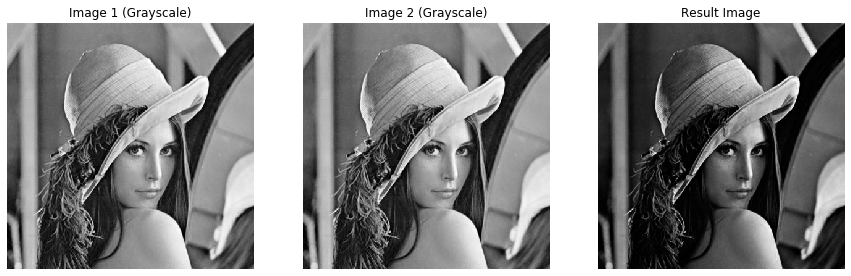

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_and_convert_to_grayscale(image_path):
    """"""
    image = Image.open(image_path).convert('L')
    return image

def multiply_images(image1, image2):
    """"""
    
    array1 = np.array(image1, dtype=np.float32)
    array2 = np.array(image2, dtype=np.float32)

    
    multiplied_array = array1 * array2
    print(multiplied_array)

    
    multiplied_array = multiplied_array / np.max(multiplied_array) * 255
    multiplied_array = multiplied_array.astype(np.uint8)

    return Image.fromarray(multiplied_array)


image1_path = 'lena.jpg'  
image2_path = 'lena.jpg'  


image1 = load_and_convert_to_grayscale(image1_path)
image2 = load_and_convert_to_grayscale(image2_path)


result_image = multiply_images(image1, image2)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1 (Grayscale)")
plt.imshow(image1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Image 2 (Grayscale)")
plt.imshow(image2, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Result Image")
plt.imshow(result_image, cmap='gray')
plt.axis('off')

plt.show()


In [2]:
from pynq import DefaultIP

class MultDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:mul:1.0']

    def mult(self, ipa1, ipa2, opa, size):
        self.write(0x34, size)
        self.write(0x10,ipa1)
        self.write(0x1c,ipa2)
        self.write(0x28,opa)
        self.register_map.CTRL.AP_START = 1
        
        return (self.read(0x10))

In [3]:
import cv2
import pynq
from pynq import Overlay, allocate
#overlay = Overlay("./design_imgmul_acc.bit")
overlay = Overlay("./design_imgmul.bit")
mul = overlay.mul_0

# allocate memory
img = cv2.imread("./lena.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rows, cols= gray.shape
input_buffer1 = allocate(shape=(rows*cols,), dtype='u1')
input_buffer2 = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u2')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer1, gray_new.flatten())
np.copyto(input_buffer2, gray_new.flatten())

In [4]:
import time
import pynq

rails = pynq.get_rails()
if 'VSYS' in rails.keys():
    print("Recording Ultra96 v1 power...")
    rail_name = 'VSYS'
elif 'INT' in rails.keys():
    print("Recording Ultra96 v2 power...")
    rail_name = 'INT'
else:
    raise RuntimeError("Cannot determine Ultra96 board version.")
recorder = pynq.DataRecorder(rails[rail_name].power)
recorder.reset()
time.sleep(2)
with recorder.record(0.01):
    recorder.mark()
    start_time = time.time()
    for _ in range(100000):
        while True:
            busy = mul.mult(input_buffer1.physical_address, input_buffer2.physical_address, output_buffer.physical_address, rows*cols)
            if busy != 1:
                break
    end_time = time.time()
    recorder.mark()
    
power_data = recorder.frame
working_power = np.mean(power_data)

print("Predict Power consumption: %.2f J" % (working_power[1] * (end_time - start_time)))

Recording Ultra96 v2 power...
Predict Power consumption: 1.45 J


In [5]:
res = output_buffer.reshape(rows, cols)

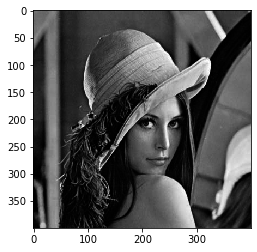

In [6]:
plt.imshow(res,cmap='gray')